# Sử dụng model Sequential và trình tạo ImageDataGenerator để load dữ liệu. Những vấn đề rút ra:  
* Xây dựng "data input pipelines" sử dụng ImageDataGenerator 
* Overfitting
* Data augmentation and dropout

### This tutorial follows a basic machine learning workflow:

* Examine and understand data
* Build an input pipeline
* Build the model
* Train the model
* Test the model
* Improve the model and repeat the process

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

### Gán các biến "train_dir" và "validation_dir" với đường dẫn đến với tệp dữ liệu tương ứng 

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [6]:
print(train_dir)

/home/quanhm/.keras/datasets/cats_and_dogs_filtered/train


In [7]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

## Understand the data

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### Fix những dữ liệu cần thiết để phục vụ cho việc học phía sau

In [10]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation : Tiền sử xử các dữ liệu ảnh trước khi đưa vào trong network
1. Đọc ảnh từ ổ đĩa
2. Decode hình ảnh và chuyển chúng về định dạng phù hợp
3. Chuyển chúng về dạng tensor
4. Điều chỉnh thang đo tensor từ 0-255 về 0-1 vì đầu vào của mạng khá nhỏ

## ImageDataGenerator có khả năng đọc các ảnh từ đĩa và chuyển chúng về dạng tensor, tiện cho việc huấn luyện

In [11]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


## Visualize training images: Hình dung về dữ liệu. Tái hiện 1 vài dữ liệu nằm trong các tập rồi vẽ chúng trên biểu đồ matplotlib

In [16]:
sample_training_images, _ = next(train_data_gen)
# Hàm next trả về 1 batch dataset. Kết quả trả về của hàm next có dạng (x_train, y_train) trong đó x_train là dữ liệu, và y_train là nhãn của chúng 
# _ để hủy nhãn, chỉ trả về training features

In [17]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

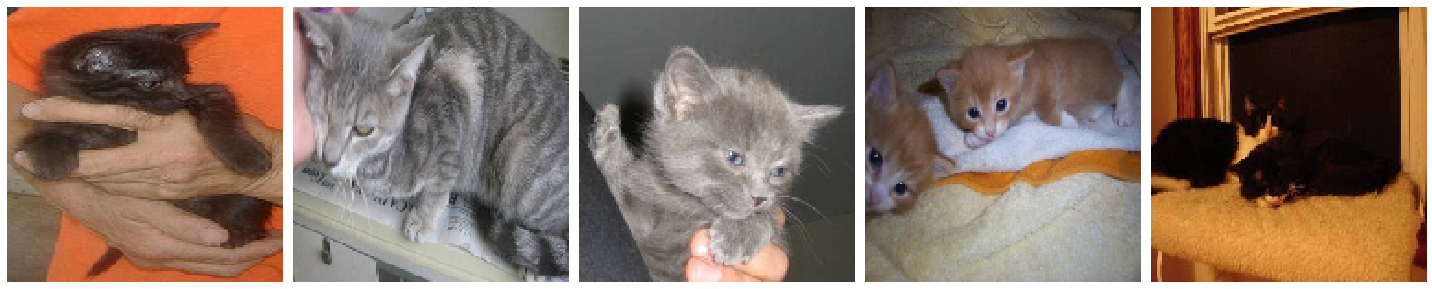

In [18]:
plotImages(sample_training_images[:5])

## Create the model

In [19]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compile the model

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### Train the model: sử dụng fit_generator trong class ImageDataGenerator để train network

In [22]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 51s 3s/step - loss: 0.8478 - accuracy: 0.5064 - val_loss: 0.6915 - val_accuracy: 0.5614
Epoch 2/15
15/15 [==============================] - 50s 3s/step - loss: 0.6813 - accuracy: 0.5865 - val_loss: 0.6503 - val_accuracy: 0.6406
Epoch 3/15
15/15 [==============================] - 51s 3s/step - loss: 0.6390 - accuracy: 0.6512 - val_loss: 0.6435 - val_accuracy: 0.6239
Epoch 4/15
15/15 [==============================] - 49s 3s/step - loss: 0.6038 - accuracy: 0.6816 - val_loss: 0.6012 - val_accuracy: 0.6629
Epoch 5/15
15/15 [==============================] - 50s 3s/step - loss: 0.5475 - accuracy: 0.7404 - val_loss: 0.6200 - val_accuracy: 0.6786
Epoch 6/15
15/15 [==============================] - 51s 3s/step - loss: 0.5220 - accuracy: 0.7401 - val_loss: 0.6262 - val_accuracy: 0.6663
Epoch 7/15
15/15 [==============================] - 52s 3s/step - loss: 0.4849 - accuracy: 0.7708 - val_loss: 0.5848 - val_accuracy: 0.7009
Epoch 8/15
15/15 [==

### Visualize training results

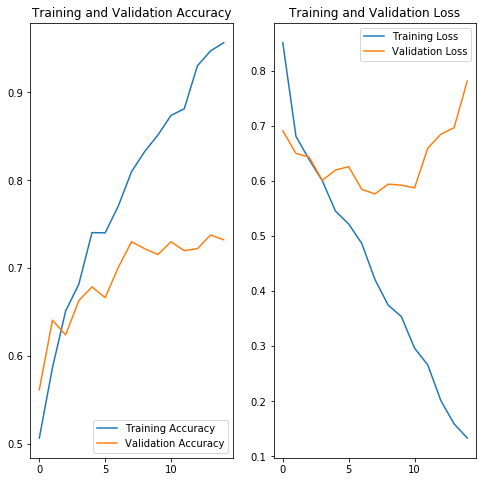

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting
* Sự khác biệt lớn giữa acc giữa training và validation là dấu hiệu của việc quá trình học bị overfiting 
* Có nhiều cách để xử lý vấn đề overfitting. Trong ví dụ này thì chúng ta sử dụng "data augmentation" và "dropout"

## Data augmentation
* Overfiting thường xảy ra khi không đủ dữ liệu trong quá trình đào tạo. 1 cách giải quyết vấn đề này là "data augmentation" nhằm làm tăng dữ liệu lên phục vụ quá trình đào tạo. 
* "data augmentation" tạo thêm dữ liệu từ các mẫu hiện có bằng cách sử dụng các phép biến đổi ngẫu nhiên mang lại hình ảnh trông có thể tin được. Mục tiêu là model không nhìn thấy một bức tranh giống hệt bức tranh lần thứ 2 trong quá trình đào tạo. Điều này giúp model thấy được dữ liệu một cách khái quát hơn

### Apply horizontal flip : Lật ngang ảnh. 

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)


In [25]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


In [26]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

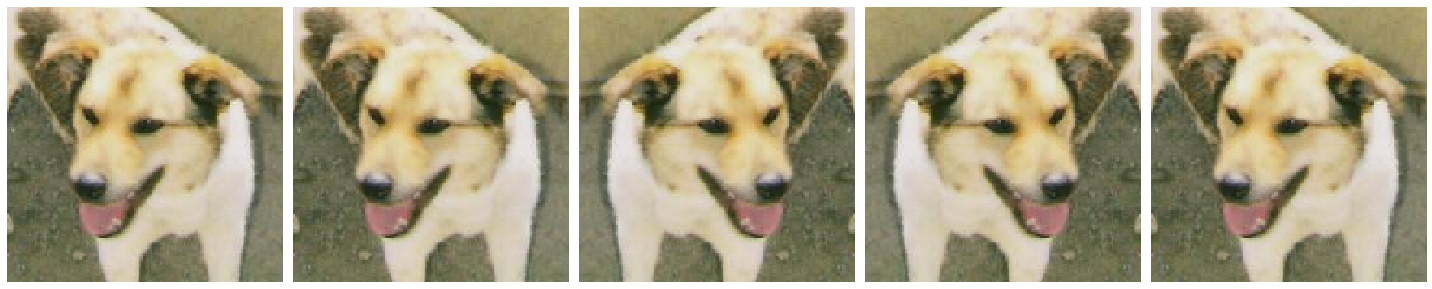

In [27]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image: Có 1 cách nhằm gia tăng dữ liệu khác là xoay dữ liệu. 

In [28]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [29]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


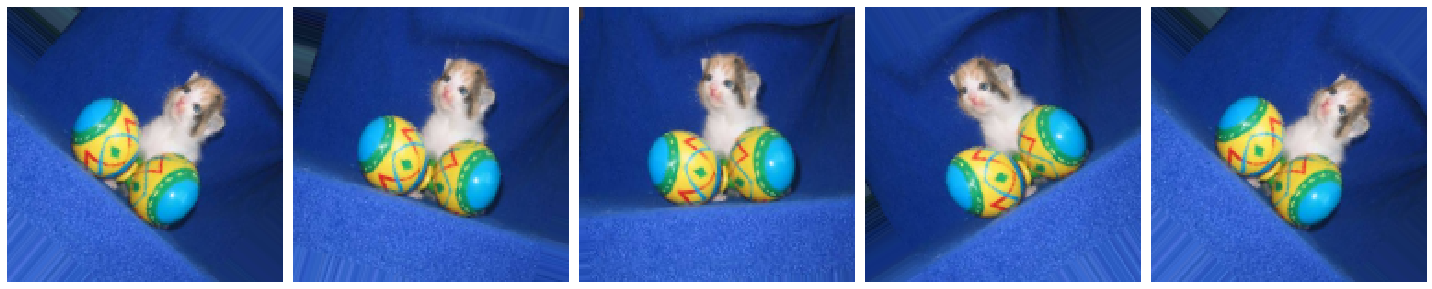

In [30]:
plotImages(augmented_images)

### Apply zoom augmentation: 1 cách khác nữa là phóng to ảnh để tăng kích thước dữ liệu 

In [31]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [32]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


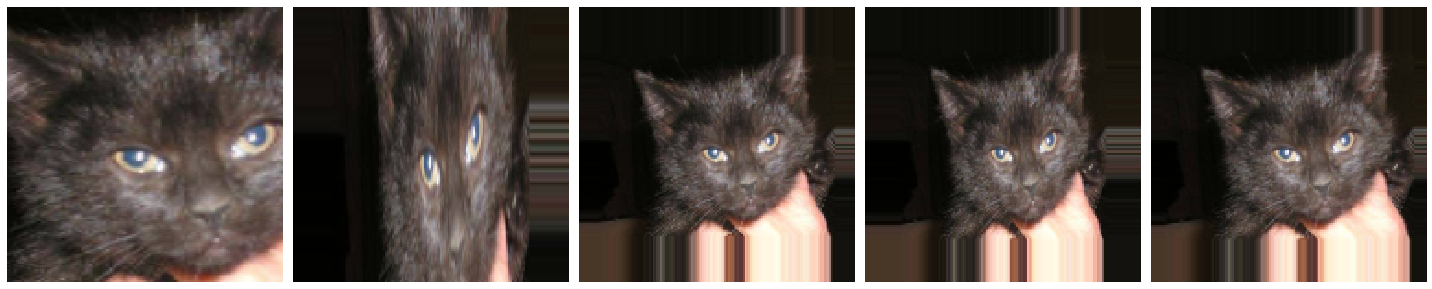

In [33]:
plotImages(augmented_images)

### Kết hợp tất cả các cách trên vào cùng nhau

In [34]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [35]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


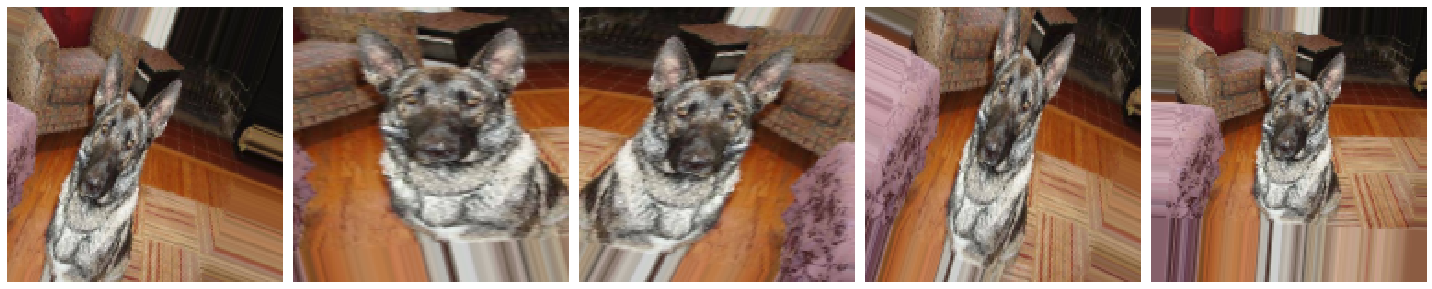

In [36]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator: Chỉ tăng kích thước dữ liệu đối với tập training, còn giữ nguyên tập validation

In [37]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [38]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Dropout 

### Creating a new network with Dropouts

In [39]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [40]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

In [41]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 64s 4s/step - loss: 0.9276 - accuracy: 0.4770 - val_loss: 0.6925 - val_accuracy: 0.5391
Epoch 2/15
15/15 [==============================] - 59s 4s/step - loss: 0.6907 - accuracy: 0.5251 - val_loss: 0.6905 - val_accuracy: 0.5100
Epoch 3/15
15/15 [==============================] - 69s 5s/step - loss: 0.6903 - accuracy: 0.5443 - val_loss: 0.6800 - val_accuracy: 0.6306
Epoch 4/15
15/15 [==============================] - 56s 4s/step - loss: 0.6665 - accuracy: 0.6063 - val_loss: 0.6515 - val_accuracy: 0.6384
Epoch 5/15
15/15 [==============================] - 59s 4s/step - loss: 0.6501 - accuracy: 0.6266 - val_loss: 0.6674 - val_accuracy: 0.6060
Epoch 6/15
15/15 [==============================] - 62s 4s/step - loss: 0.6610 - accuracy: 0.6058 - val_loss: 0.6412 - val_accuracy: 0.6663
Epoch 7/15
15/15 [==============================] - 54s 4s/step - loss: 0.6523 - accuracy: 0.6321 - val_loss: 0.6362 - val_accuracy: 0.6540
Epoch 8/15
15/15 [==

### Visualize the model

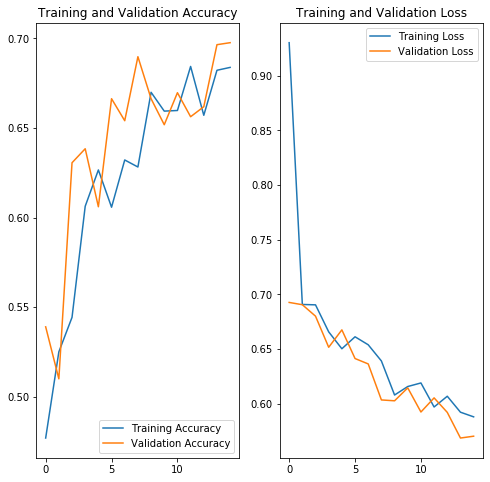

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()